In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

Today, let's look at Amtrak arrival and departure data provided by [AMSAD](https://juckins.net/amtrak_status/archive/html/home.php), and use it to predict arrival delays.

I'd like to thank Chris, the retainer of ASMAD for helping provide the data, and for his support answering by various questions.

In [2]:
 df = pd.read_csv('status.csv')

**Column Names & Descriptions**
- no - Train Number
- origin_date
- sta_no - Station Number (nth station of the train line for that day)
- station - Station Name
- schArDay - Scheduled Arrival Day, where 1 is same day, 2 is the next day, and 3 is 2 days after departure
- schAr - Scheduled Arrival
- actAr - Actual Arrival
- schDpDay - Scheduled Departure Day
- schDp - Scheduled Departure
- actDp - Actual Departure
- d_ar - Delay (Arrival)
- d_dp - Delay (Departure)

In [3]:
df.head()

,no,origin_date,sta_no,station,schArDay,schAr,actAr,schDpDay,schDp,actDp,d_ar,d_dp,comments,updated
0,126,2018-01-01,NaN,WAS,NaN,NaN,NaN,1.0,2018-01-01 16:25:00,4:25PM,NaN,0.0,Departed: On time.,2019-03-26 00:00:00
1,126,2018-01-01,NaN,NCR,NaN,NaN,NaN,1.0,2018-01-01 16:36:00,4:40PM,NaN,4.0,Departed: 4 minutes late.,2019-03-26 00:00:00
2,126,2018-01-01,NaN,BWI,NaN,NaN,NaN,1.0,2018-01-01 16:51:00,4:56PM,NaN,5.0,Departed: 5 minutes late.,2019-03-26 00:00:00
3,126,2018-01-01,NaN,BAL,1.0,2018-01-01 17:05:00,5:08PM,1.0,2018-01-01 17:07:00,5:11PM,3.0,4.0,Arrived: 3 minutes late. | Depart...,2019-03-26 00:00:00
4,126,2018-01-01,NaN,WIL,1.0,2018-01-01 17:53:00,5:54PM,1.0,2018-01-01 17:55:00,5:57PM,1.0,2.0,Arrived: 1 minute late. | Depart...,2019-03-26 00:00:00


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8978660 entries, 0 to 8978659
Data columns (total 14 columns):
 #   Column       Dtype  
---  ------       -----  
 0   no           int64  
 1   origin_date  object 
 2   sta_no       float64
 3   station      object 
 4   schArDay     float64
 5   schAr        object 
 6   actAr        object 
 7   schDpDay     float64
 8   schDp        object 
 9   actDp        object 
 10  d_ar         float64
 11  d_dp         float64
 12  comments     object 
 13  updated      object 
dtypes: float64(5), int64(1), object(8)
memory usage: 959.0+ MB


In [3]:
df.isna().sum().sort_values()

no                   0
origin_date          0
station              0
updated              0
comments        107932
schDpDay        637048
schDp           637049
d_dp            930917
actDp           931258
sta_no         6293892
schArDay       6774781
schAr          6774899
actAr          6826568
d_ar           6827100
dtype: int64

<h2>Imputation<h2>

<h3>Station Number<h3>

Although we always have train number and station name, in the majority of places we have no station number. My hunch is that `sta_no` will be an important feature because according to data pulled from ASMAD, the further down you are on a given train ride [the larger your average delay.](https://juckins.net/amtrak_status/archive/html/average_delays.php?train_num=14&date_start=09%2F10%2F2024&date_end=10%2F10%2F2024&df1=1&df2=1&df3=1&df4=1&df5=1&df6=1&df7=1&stat=avg&chartsize=2&dfon=1) Let's clean `sta_no` up.

Since `schDp` is available in the vast majority of cases (only 7% missing), we can simply complete the sequences by ordering on that.

In cases where schDp is unavailable, let's not make an imputation for now.

In [4]:
len(df.schDp[df.schDp.isna()])/df.shape[0]

0.0709514560079121

In [5]:
len(df.schDp[df.schDp.isna()])

637049

In [6]:
df = df.sort_values(by=['no', 'origin_date','schDpDay','schDp'])

# Filter only rows where 'schDp' is not null and assign sequential 'sta_no'
# Keep track of schDpDay for multi-day journeys
df_non_null_schDp = df[df['schDp'].notna()]

df_non_null_schDp['sta_no'] = df_non_null_schDp.groupby(['no', 'origin_date']).cumcount() + 1

/var/folders/4y/8dj_s7d12jn3gqzqszzgtfnr0000gn/T/ipykernel_44406/4047207473.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_null_schDp['sta_no'] = df_non_null_schDp.groupby(['no', 'origin_date']).cumcount() + 1


In [7]:
sta_no_mapping = (
    df_non_null_schDp.dropna(subset=['sta_no'])
    .set_index(['no', 'origin_date', 'schDp', 'schDpDay'])['sta_no']
    .to_dict()
)

# Step 2: Apply the mapping to fill 'sta_no' in the original DataFrame
# For each row, check if there’s a corresponding value in the mapping dictionary
df['sta_no'] = df.apply(
    lambda row: sta_no_mapping.get((row['no'], row['origin_date'], row['schDp'], row['schDpDay']), row['sta_no']),
    axis=1
)

In [8]:
len(df.sta_no[df.sta_no.isna()])/df.shape[0]

0.049852650618243705

Terminus stations have no `schDp`, but they do have `schAr`. The other stations generally have `schDp` but no `schAr`. In such places, where the previous row is also the same `no` and `origin_date`, let's impute the previous station number plus 1.

In [9]:
df['prev_schDp'] = df.schDp.shift(1)
df['prev_schAr'] = df.schAr.shift(1)
df['prev_no'] = df.no.shift(1)
df['prev_sta_no'] = df.sta_no.shift(1)
df['prev_origin_date'] = df.origin_date.shift(1)

terminus_conditions = (
    df['sta_no'].isna() &
    df['schDp'].isna() &
    df['schAr'].notna() &
    (df['no'] == df['no'].shift(1)) &
    (df['origin_date'] == df['origin_date'].shift(1))
)

df.loc[terminus_conditions,'sta_no'] = df.loc[terminus_conditions,'prev_sta_no'] +1

If we check the comments, we see that the remaining terminus stations with no `sta_no` are like that because the train never got there.

In [10]:
df[terminus_conditions & (df.sta_no.isna())].head()

,no,origin_date,sta_no,station,schArDay,schAr,actAr,schDpDay,schDp,actDp,d_ar,d_dp,comments,updated,prev_schDp,prev_schAr,prev_no,prev_sta_no,prev_origin_date
5510070,1,2022-04-30,NaN,LAX,3.0,2022-05-02 05:35:00,NaN,NaN,NaN,NaN,NaN,NaN,PT Station Stop Canceled,2022-05-05 04:06:23,NaN,2022-05-01 13:22:00,1.0,NaN,2022-04-30
2298318,2,2019-07-14,NaN,NOL,3.0,2019-07-16 21:40:00,NaN,NaN,NaN,NaN,NaN,NaN,CT Station Stop Canceled,2019-07-17 04:06:32,NaN,2019-07-16 06:25:00,2.0,NaN,2019-07-14
3682848,2,2020-08-23,NaN,NOL,3.0,2020-08-25 21:40:00,NaN,NaN,NaN,NaN,NaN,NaN,CT Station Stop Canceled,2021-01-25 09:36:25,NaN,2020-08-25 04:50:00,2.0,NaN,2020-08-23
3700463,2,2020-08-30,NaN,NOL,3.0,2020-09-01 21:40:00,NaN,NaN,NaN,NaN,NaN,NaN,CT Station Stop Canceled,2021-01-25 09:36:25,NaN,2020-09-01 04:50:00,2.0,NaN,2020-08-30
3802447,2,2020-10-07,NaN,NOL,3.0,2020-10-09 21:40:00,NaN,NaN,NaN,NaN,NaN,NaN,CT Station Stop Canceled,2021-01-25 09:36:28,NaN,2020-10-09 04:50:00,2.0,NaN,2020-10-07


In [11]:
len(df.sta_no[df.sta_no.isna()])

1247

In [12]:
len(df.sta_no[df.sta_no.isna()])/df.shape[0]

0.00013888486700688077

The vast number `sta_no` values have been imputed! We can drop the remaining rows in this case, because we are trying to predict delays, not canellations.

In [13]:
df = df.dropna(subset=['sta_no'])

In [14]:
df.isna().sum().sort_values()

no                        0
origin_date               0
sta_no                    0
station                   0
updated                   0
prev_no                   1
prev_origin_date          1
comments             107903
prev_sta_no          446377
schDpDay             635801
schDp                635802
prev_schDp           635815
d_dp                 929672
actDp                930013
schArDay            6774767
prev_schAr          6774873
schAr               6774885
actAr               6825334
d_ar                6825866
dtype: int64

<h3>Arrival & Departure Times, Delays<h3>

There's a lot of information missing about arrival times. About 75% is missing, in fact (although it is reliably there for terminus stations)! This is a constraint of the data supplied by Amtrak.

In [15]:
df.schAr.isna().sum()/len(df.schAr)

np.float64(0.7546589423924241)

In [16]:
df.actAr.isna().sum()/len(df.actAr)

np.float64(0.760278490028252)

In [17]:
df.d_ar.isna().sum()/df.shape[0]

np.float64(0.760337749861792)

<h4>schAr<h4>

Now, let's make some imputations for the missing scheduled arrival values using previous values for the same train, station, and day of the week. Importantly, each train has a Weekday schedule, a Saturday schedule, and a Sunday schedule. If there is no non-null value available for that specific weekday, then we want to expand our search to check for other weekdays. If multiple values are availble for the train, station, and day of week, we'll choose the most recent one.

In [18]:
#Convert these columns to datetime
df['origin_date'] = pd.to_datetime(df['origin_date'], errors='coerce')
df['schAr'] = pd.to_datetime(df['schAr'], errors='coerce')
df['actAr'] = pd.to_datetime(df['actAr'], errors='coerce')
df['schDp'] = pd.to_datetime(df['schDp'], errors='coerce')
df['actDp'] = pd.to_datetime(df['actDp'], errors='coerce')

#Add a column for the day of the week (0 = Monday, ..., 6 = Sunday)
df['origin_day_of_week'] = df['origin_date'].dt.dayofweek

# Sort values by 'train number', 'station number', and 'schAr' to ensure proper order
df = df.sort_values(by=['no', 'origin_date','sta_no'])

# Group by 'train number', 'station number', and 'day of week'
# Fill missing 'schAr' with forward-fill within each group to fill NaNs with most recent non-null value
df['schAr_filled'] = df.groupby(['no', 'sta_no', 'origin_day_of_week'])['schAr'].transform(lambda x: x.ffill())

# Handle cases where weekdays (day_of_week < 5) should share schedules
# First, create a mask for weekdays only
weekday_mask = df['origin_day_of_week'] < 5

# Now, fill within weekdays (Monday-Friday) across all groups by train number and station number
df.loc[weekday_mask, 'schAr_filled'] = df[weekday_mask].groupby(['no', 'sta_no'])['schAr_filled'].transform(lambda x: x.ffill())

# Replace original 'schAr' with filled values
df['schAr'] = df['schAr'].fillna(df['schAr_filled'])

/var/folders/4y/8dj_s7d12jn3gqzqszzgtfnr0000gn/T/ipykernel_44406/1243343594.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['actAr'] = pd.to_datetime(df['actAr'], errors='coerce')
/var/folders/4y/8dj_s7d12jn3gqzqszzgtfnr0000gn/T/ipykernel_44406/1243343594.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['actDp'] = pd.to_datetime(df['actDp'], errors='coerce')


In [19]:
df.schAr.isna().sum()/len(df.schAr)

np.float64(0.31403456652824147)

We've reduced missing values for `schAr` from 75% to 31%!

<h4>actAr & actDp<h4>

In order to reduce the number of NaN values for `actAr`, let's assume it's the same as `actDp` in all places where the train left on time. This may miss cases where the train arrived early (not logged) and then waited until the scheduled departure time to depart, but I'm going to assume that's fine.

In such cases, we'll infer that `actAr = schAr = actDp`, and that d_ar is 0.

In [20]:
# Create a condition where actAr and schAr are NaN and d_dp is 0
no_arr = df['actAr'].isnull() & df['schAr'].isnull() & df['d_ar'].isnull() & (df['d_dp'] == 0)


# Assign actDp to both actAr and schAr, and set d_ar to 0 for rows that satisfy the condition
df.loc[no_arr, ['actAr', 'schAr']] = df['actDp']
df.loc[no_arr, 'd_ar'] = 0

In [21]:
df[no_arr].shape

(903780, 21)

In cases where `actDp` is actually BEFORE `schAr`, we can infer that the train arrived early and departed early, i.e. `actAr = actDp < schAr`. 

In [22]:
df.loc[df['actDp'] < df['schAr'], 'actAr'] = df['actDp']

Let's check the NaNs now.

In [23]:
df.schAr.isna().sum()/len(df.schAr)

np.float64(0.21339922759485389)

In [24]:
df.actAr.isna().sum()/len(df.actAr)

np.float64(0.6596431510948644)

In [26]:
df.d_ar.isna().sum()/len(df.d_ar)

np.float64(0.6596650950557805)

We reduced the NaN values for `schAr` from about 75% to 3%, and `actAr` and `d_ar` to 66%. Let's spot check a couple. 

In [27]:
df.sample(n=5)

,no,origin_date,sta_no,station,schArDay,schAr,actAr,schDpDay,schDp,actDp,...,d_dp,comments,updated,prev_schDp,prev_schAr,prev_no,prev_sta_no,prev_origin_date,origin_day_of_week,schAr_filled
753207,354,2018-07-04,12.0,ROY,NaN,2018-03-15 00:18:00,NaT,2.0,2018-07-05 00:18:00,2024-10-12 01:21:00,...,63.0,"Departed: 1 hour, 3 minutes late.",2019-03-26 00:00:00,2018-07-04 23:54:00,2018-07-04 23:54:00,354.0,11.0,2018-07-04,2,2018-03-15 00:18:00
3279879,86,2020-03-05,2.0,ASD,NaN,NaT,NaT,1.0,2020-03-05 06:13:00,2024-10-12 06:20:00,...,7.0,Departed: 7 minutes late.,2021-01-25 11:40:00,2020-03-05 06:00:00,NaN,86.0,1.0,2020-03-05,3,NaT
3874043,710,2020-11-05,9.0,MCD,NaN,NaT,NaT,1.0,2020-11-05 10:45:00,2024-10-12 10:51:00,...,6.0,Departed: 6 minutes late.,2021-01-25 11:17:27,2020-11-05 10:12:00,NaN,710.0,8.0,2020-11-05,3,NaT
5385198,56,2022-03-23,19.0,GFD,NaN,2021-12-01 16:22:00,NaT,1.0,2022-03-23 16:22:00,2024-10-12 16:22:00,...,0.0,Departed: On time.,2022-03-24 04:27:59,2022-03-23 15:57:00,NaN,56.0,18.0,2022-03-23,2,2021-12-01 16:22:00
928017,684,2018-08-16,11.0,WOB,NaN,2018-04-26 14:25:00,NaT,1.0,2018-08-16 14:04:00,2024-10-12 14:10:00,...,6.0,Departed: 6 minutes late.,2019-03-26 00:00:00,2018-08-16 13:35:00,NaN,684.0,10.0,2018-08-16,3,2018-04-26 14:25:00


<h3>More on `d_ar`<h3>

In [28]:
df.isna().sum().sort_values()

no                          0
origin_date                 0
sta_no                      0
station                     0
origin_day_of_week          0
updated                     0
prev_origin_date            1
prev_no                     1
comments               107903
prev_sta_no            446377
schDpDay               635801
schDp                  635803
prev_schDp             635815
d_dp                   929672
actDp                  930013
schAr                 1915773
schAr_filled          2819218
actAr                 5921889
d_ar                  5922086
schArDay              6774767
prev_schAr            6774873
dtype: int64

Arrival delay, `d_ar` is the variable we are going to predict, so it's crucial that we minimize the number of missing values in a way that we can trust. For pairs of stops where there is a departure delay and arrival information is available, is there a predictable relationship? Let's try to regress `d_ar` on `d_dp` of the previous station.

In [29]:
#Sort the dataframe by train number and station number to ensure correct sequence
df = df.sort_values(by=['no', 'origin_date','sta_no'])

# Create a mask to identify where train number resets
reset_mask = (df['no'] != df['no'].shift(1))

# Shift the d_dp column by one row to align with the next station's actAr
df['prev_d_dp'] = df['d_dp'].shift(1)

# Invalidate the prev_d_Dp values where no reset occurs
df.loc[reset_mask, 'prev_d_dp'] = pd.NA 

valid_rows = df[(df['d_ar'].isnull()==False)&(df['prev_d_dp'].isnull()==False)]

# Optional: Analyze the relationship
# For example, you can check the correlation between actAr and prev_actDp
correlation = valid_rows['d_ar'].astype('int64').corr(valid_rows['prev_d_dp'].astype('int64'))

correlation

np.float64(0.9531905243618051)

95%!

Now, for the sake of train error purposes, let's keep our original `d_ar` values as they are for now with only our rule of thumb imputations.

Since we know that, where both are available, `d_ar` is 95% correlated with `prev_d_dp`, let's make a `d_ar_filled` in which we predict based on the equation `d_ar = beta1 * prev_d_dp + beta2 * c + error`.

Let's check the coverage of observations where `d_ar` and `prev_d_dp` are both non-NaN.

In [30]:
df[(df.d_ar.isnull() == False)&(df.prev_d_dp.isnull() == False)].shape

(2521750, 22)

In [31]:
df[(df.d_ar.isnull() == False)&(df.prev_d_dp.isnull() == False)].shape[0]/df.shape[0]

0.28089940832620713

Only about 28%. We should proceed with caution before using this to impute on every single train and station. Let's use some additional domain knowledge I got from the maintainer of the [Status Maps Database](https://juckins.net/amtrak_status/archive/html/home.php).

A key place where `d_ar` will have a weaker correlation to `prev_d_dp` is in places where Amtrak puts recovery time or "padding" between certain stations. For example, there is a sizeable pad on the Coast Starlight #14 between Salem and Portland. The train might [leave Salem late and still arrive Portland early](https://asm.transitdocs.com/train/2024/9/5/A/14).

It's difficult to catch all the cases of padding, but we can get pretty far with two observations:

- It happens more on overnight trains, allowing the passengers to rest instead of arriving at their destination early and waking everyone up.
- It tends to happen between penultimate stations and termini so that there are more on-time arrivals at termini. (In fact, it's a leftover practice from when on-time performance metrics weren't kept at the individual stations, but just at the terminus. More recently, all stops are considered when calculating on-time performance, and the practice has diminished somewhat, but hasn't gone away.)

Given that, it seems safest to exclude **overnight** trains and **terminus** stations from our imputation process. Let's check how significant these cases are.

In [32]:
# Sort the DataFrame by 'no', 'origin_date', and 'sta_no'
df = df.sort_values(by=['no', 'origin_date', 'sta_no'])

#remove NaN values
df_term = df.dropna(subset=['no', 'origin_date','sta_no'])

terminus_indices = df_term.groupby(['no', 'origin_date'])['sta_no'].idxmax()

# Group by 'no' and 'origin_date', and select the row with the maximum 'sta_no' within each group
df_term = df_term.loc[terminus_indices]

In [33]:
df_term.shape[0]/df.shape[0]

0.07075991713871245

In [34]:
overnight_journeys = df.groupby(['no', 'origin_date']).filter(lambda x: (x['schArDay'] > 1).any())

In [35]:
overnight_journeys.shape[0]/df.shape[0]

0.22908381289799187

In [36]:
(df_term.shape[0] + overnight_journeys.shape[0])/df.shape[0]

0.29984373003670434

Looks like 30% of stops fall into one of these edge cases.

In [37]:
#start by filling all existing values
df['d_ar_filled'] = df.d_ar

exclude_indices = set(df_term.index).union(set(overnight_journeys.index))

# Prepare data for regression where both 'd_ar' and 'prev_d_dp' are not NaN
# Additionally, exclude indices from terminus_stations and overnight_journeys
train_data = df.dropna(subset=['d_ar', 'prev_d_dp'])

In [38]:
train_data.shape

(2521750, 23)

Ultimately, test error will determine if we have a problem here, but caution seems warranted because we are about to imput about 7M values in our `y_train` based on a relationship observed in only 2.4M values. 

If we don't have any existing `d_ar` data **at all** for a given train number, it seems a bit cavalier to assume it is going to have the same strong correlation between `d_ar` and `prev_d_dp`. 

Let's check if all train (as in locomotive) numbers are represented in the training data.

In [39]:
missing_no_values = df[~df['no'].isin(train_data['no'])]['no'].unique()
missing_no_values = pd.Series(missing_no_values)

In [42]:
missing_no_values

0     377
1     515
2     533
3     922
4    1297
5    1448
6    3596
7    9992
dtype: int64

In [41]:
missing_no_values[missing_no_values.isin(overnight_journeys['no'])]

7    9992
dtype: int64

From spot checks on [Rail Rat](https://railrat.net/trains/), the only trains in this list still operational are 533, 922, 1297, and 1448. Others are one-off train numbers created in cases where track work makes it such that two trains of the same number actually end up running on the same day. To prevent inconsistencies, Amtrak creates a new number for the second train. Manual inspection found that each train number has at least one valid `d_ar` value.

In [52]:
df.loc[df.no.isin([533, 922, 1297, 1448]),['no','origin_date','d_ar']].tail()

,no,origin_date,d_ar
739811,1448,2018-05-25,110.0
739812,1448,2018-05-25,NaN
739813,1448,2018-05-25,NaN
739814,1448,2018-05-25,NaN
739815,1448,2018-05-25,126.0


For now, we'll proceed to impute the rest of the values, even for trains for which we have no observed `d_ar` values, as long as they are not overnight trains.

Perhaps for overnight trains, we can make a separate correlation check and regression imputation.

In [54]:
overnight_journeys['d_ar'].corr(overnight_journeys['prev_d_dp'])

np.float64(0.9549752855446062)


Oh wow, It's still very tight! What about for teminus stations?

In [64]:
df_term['d_ar'].corr(df_term['prev_d_dp'])

np.float64(0.9277966755584122)

Not quite as high, but I'm still willing to live with 92% correlation.

Let's skip the exclusion for now, and we can always return to this part if prediction accuracy for overnight and terminus stations is low.

In [53]:
train_data.shape

(2521750, 23)

In [54]:
# Define features and target variable
X_train = train_data[['prev_d_dp']].values  # Feature
y_train = train_data['d_ar'].values         # Target

#Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict missing 'd_ar' values where 'd_ar' is NaN but 'prev_d_dp' is not NaN
missing_d_ar = (df['d_ar'].isna() & df['prev_d_dp'].notna())
X_missing = df.loc[missing_d_ar, 'prev_d_dp'].values.reshape(-1, 1)

# Impute 'd_ar_filled' only for the rows not in the exclusion set
df.loc[missing_d_ar, 'd_ar_filled'] = model.predict(X_missing)

In [55]:
df.d_ar_filled.isna().sum()/len(df.d_ar)

np.float64(0.04412128527449946)

This gets our `d_ar` missing values down to 4%. Let's inspect the imputed values.

In [56]:
df.d_ar_filled.sample(n=20)

7625540    -3.000000
1190917     4.833136
6468721     4.833136
1089867    18.279823
1444543    46.133675
1671656    54.777974
5458307     8.675046
1123366     0.000000
6533332    -1.890208
3776237    16.358868
8609688     3.872658
5711075    -2.850685
8952858     5.793613
1360051    -1.890208
1873859          NaN
5539155    -2.850685
4454065     0.000000
2168022     0.000000
8890472     0.000000
518143      2.912181
Name: d_ar_filled, dtype: float64

In [57]:
df.d_ar_filled.describe()

count    8.581318e+06
mean     1.330288e+01
std      4.432669e+01
min     -5.290000e+02
25%     -1.890208e+00
50%      3.074754e-02
75%      1.000000e+01
max      2.551000e+03
Name: d_ar_filled, dtype: float64

<Axes: >

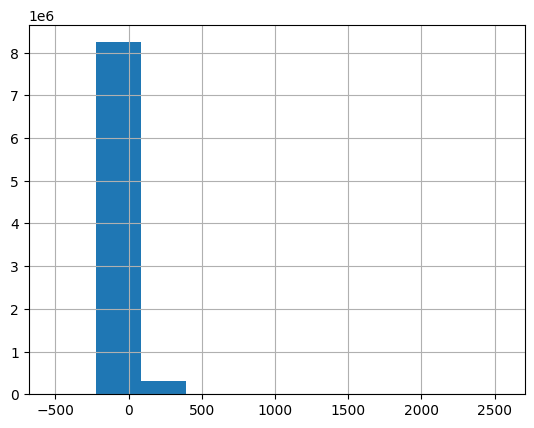

In [58]:
df.d_ar_filled.hist()

Looks like there are some outliers, so we may have to remove those in any steps where we use linear regression. Nonlinear regression techniques will be fine as is.

In [59]:
df.isna().sum().sort_values()

no                          0
origin_date                 0
sta_no                      0
station                     0
origin_day_of_week          0
updated                     0
prev_origin_date            1
prev_no                     1
comments               107903
d_ar_filled            396095
prev_sta_no            446377
schDpDay               635801
schDp                  635803
prev_schDp             635815
prev_d_dp              929672
d_dp                   929672
actDp                  930013
schAr                 1915773
schAr_filled          2819218
actAr                 5921889
d_ar                  5922086
schArDay              6774767
prev_schAr            6774873
dtype: int64

In [60]:
df.to_csv('AmtrakDataImputed.csv')

In [61]:
df.shape

(8977413, 23)

<h2>Feature Engineering<h2>

<h3>Train & Station Features<h3>

- no
- sta_no
- Train Type

We should convert `no` and `sta_no` into categoricals for final prediction to avoid the inference of a numerical relationship. Once we take care of that, however, these features will be important to included to catch whether a certain train or station tends to have more delays. For example, long distance trains traveling coast to coast have a higher chance of encountering a crossing with freight trains, a case in which they can experience major delays. This will help to catch that.

In [59]:
X = pd.DataFrame()

In [60]:
df['no'] = df['no'].astype(str)
df['sta_no'] = df['sta_no'].astype(str)
X = pd.concat([X, df[['no','sta_no']]], axis=1)

Amtrak organizes their trains into three groups: Northeast Corridor (NEC), State-Supported, and Long Distance. NEC trains, especially Acela trains, are least prone to delay. State-Supported next least, and Long Distance the most. As described above, Long Distance trains are most prone to delays because they intersect with freight trains. Let's add train categories for:
- NEC Acela
- NEC Regional
- State Supported
- Long Distance

In [61]:
X.head()

,no,sta_no
2503,1,1.0
2504,1,2.0
2505,1,3.0
2506,1,4.0
2507,1,5.0


<h3>Date Transformation Features<h3>

`origin_date`

- Day of Week (weekly seasonality)
- Day of Month (monthly seasonality)
- Month of Year (yearly seasonality)
- Days since beginning (track change over time)

`schDpDay`
- Catch any tendency for more or less delay on later days of journey. (Not independent from `sta_no`, so maybe leave out of initial predictive analysis)

<h3>Date Transformation Features<h3>

In [75]:
df.head()

,no,origin_date,sta_no,station,schArDay,schAr,actAr,schDpDay,schDp,actDp,...,comments,updated,prev_schDp,prev_schAr,prev_no,prev_origin_date,prev_sta_no,origin_day_of_week,schAr_filled,prev_d_dp
2503,1,2018-01-01,1.0,NOL,NaN,2024-10-11 09:00:00,2024-10-11 09:00:00,1.0,2018-01-01 09:00:00,2024-10-11 09:00:00,...,Departed: On time.,2019-03-26 00:00:00,None,None,NaN,None,NaN,0,2024-10-11 09:00:00,NaN
2504,1,2018-01-01,2.0,SCH,NaN,NaT,NaT,1.0,2018-01-01 10:30:00,2024-10-11 13:27:00,...,"Departed: 2 hours, 57 minutes late.",2019-03-26 00:00:00,2018-01-01 09:00:00,NaN,1.0,2018-01-01,1.0,0,NaT,0.0
2505,1,2018-01-01,3.0,NIB,NaN,NaT,NaT,1.0,2018-01-01 11:56:00,2024-10-11 14:45:00,...,"Departed: 2 hours, 49 minutes late.",2019-03-26 00:00:00,2018-01-01 10:30:00,NaN,1.0,2018-01-01,2.0,0,NaT,177.0
2506,1,2018-01-01,4.0,LFT,1.0,2018-01-01 12:24:00,2024-10-11 15:07:00,1.0,2018-01-01 12:24:00,2024-10-11 15:13:00,...,"Arrived: 2 hours, 43 minutes late. | Depart...",2019-03-26 00:00:00,2018-01-01 11:56:00,NaN,1.0,2018-01-01,3.0,0,2018-01-01 12:24:00,169.0
2507,1,2018-01-01,5.0,LCH,NaN,NaT,NaT,1.0,2018-01-01 13:55:00,2024-10-11 16:49:00,...,"Departed: 2 hours, 54 minutes late.",2019-03-26 00:00:00,2018-01-01 12:24:00,2018-01-01 12:24:00,1.0,2018-01-01,4.0,0,NaT,169.0


<h2>Training & Prediction<h2>